In [1]:
import os
import pickle

In [2]:
#change working directory
os.chdir('/work/postresearch/Shared/Researchers/Farbod/cancer')

INFO:Simulating initial volumes for stage I  with norm params: mu=1.72, sigma=4.7, lb=-0.6221218732608375, ub=-0.023523848418276528
INFO:Simulating initial volumes for stage II  with norm params: mu=1.96, sigma=1.63, lb=-1.9410876100159118, ub=0.3711345751297772
INFO:Simulating initial volumes for stage IIIA  with norm params: mu=1.91, sigma=9.4, lb=-0.33127370258786554, ub=0.06967546355973796
INFO:Simulating initial volumes for stage IIIB  with norm params: mu=2.76, sigma=6.87, lb=-0.5769974969906748, ub=-0.02839165102452155
INFO:Simulating initial volumes for stage IV  with norm params: mu=3.86, sigma=8.82, lb=-0.5741465764541878, ub=-0.14683113860980307
INFO:Got correlated params for 4597 patients
INFO:Got correlated params for 9177 patients
INFO:Got correlated params for 13793 patients
INFO:Simulating beta_c parameters
INFO:Randomising outputs
  0%|                                                                                                                               | 0/1000

Call to simulate counterfactuals data


  8%|█████████▏                                                                                                             | 77/1000 [00:01<00:17, 53.32it/s]/tmp/ipykernel_3384/2238565012.py:734: RuntimeWarning: invalid value encountered in log
  (1 + rho * np.log(K / (counterfactual_cancer_volume[current_t] + 1e-07) + 1e-07) -
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.38it/s]


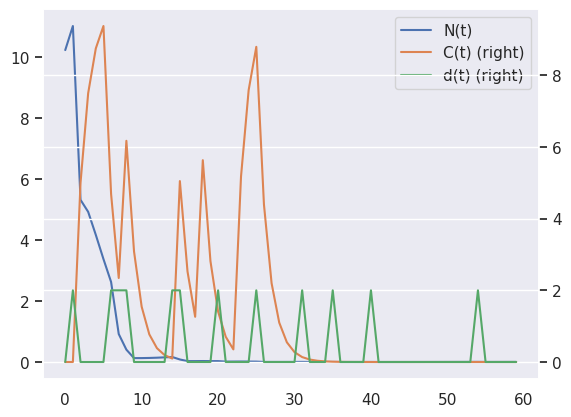

In [4]:
# -*- coding: utf-8 -*-
"""
[Treatment Effects with RNNs] cancer_simulation
Created on 2/4/2018 8:14 AM

Medically realistic data simulation for small-cell lung cancer based on Geng et al 2017.
URL: https://www.nature.com/articles/s41598-017-13646-z

Notes:
- Simulation time taken to be in days

@author: limsi
"""

import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import truncnorm  # we need to sample from truncated normal distributions

sns.set()


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Simulation Constants

# Spherical calculations - tumours assumed to be spherical per Winer-Muram et al 2002.
# URL:
# https://pubs.rsna.org/doi/10.1148/radiol.2233011026?url_ver=Z39.88-2003&rfr_id=ori%3Arid%3Acrossref.org&rfr_dat=cr_pub%3Dpubmed


def calc_volume(diameter):
    return 4 / 3 * np.pi * (diameter / 2) ** 3


def calc_diameter(volume):
    return ((volume / (4 / 3 * np.pi)) ** (1 / 3)) * 2


# Tumour constants per
TUMOUR_CELL_DENSITY = 5.8 * 10 ** 8  # cells per cm^3
TUMOUR_DEATH_THRESHOLD = calc_volume(13)  # assume spherical

# Patient cancer stage. (mu, sigma, lower bound, upper bound) - for lognormal dist
tumour_size_distributions = {'I': (1.72, 4.70, 0.3, 5.0),
                             'II': (1.96, 1.63, 0.3, 13.0),
                             'IIIA': (1.91, 9.40, 0.3, 13.0),
                             'IIIB': (2.76, 6.87, 0.3, 13.0),
                             'IV': (3.86, 8.82, 0.3, 13.0)}  # 13.0 is the death condition

# Observations of stage proportions taken from Detterbeck and Gibson 2008
# - URL: http://www.jto.org/article/S1556-0864(15)33353-0/fulltext#cesec50\
cancer_stage_observations = {'I': 1432,
                             "II": 128,
                             "IIIA": 1306,
                             "IIIB": 7248,
                             "IV": 12840}


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Simulation Functions


def generate_params(num_patients, chemo_coeff, radio_coeff, lag, window_size = 15):
    """
    Get original patient-specific simulation parameters, and add extra ones to control confounding

    :param num_patients: Number of patients to simulate
    :param chemo_coeff: Bias on action policy for chemotherapy assignments
    :param radio_activation_group: Bias on action policy for chemotherapy assignments
    :return: dict of parameters
    """

    basic_params = get_standard_params(num_patients)
    patient_types = basic_params['patient_types']
    # tumour_stage_centres = [s for s in cancer_stage_observations if 'IIIA' not in s]
    # tumour_stage_centres.sort()

    # Parameters controlling sigmoid application probabilities

    D_MAX = calc_diameter(TUMOUR_DEATH_THRESHOLD)
    basic_params['chemo_sigmoid_intercepts'] = np.array([D_MAX / 2.0 for _ in patient_types])
    basic_params['radio_sigmoid_intercepts'] = np.array([D_MAX / 2.0 for _ in patient_types])

    basic_params['chemo_sigmoid_betas'] = np.array([chemo_coeff / D_MAX for _ in patient_types])
    basic_params['radio_sigmoid_betas'] = np.array([radio_coeff / D_MAX for _ in patient_types])

    basic_params['window_size'] = window_size
    basic_params['lag'] = lag

    return basic_params


def get_standard_params(num_patients):  # additional params
    """
    Simulation parameters from the Nature article + adjustments for static variables

    :param num_patients: Number of patients to simulate
    :return: simulation_parameters: Initial volumes + Static variables (e.g. response to treatment); randomly shuffled
    """

    # INITIAL VOLUMES SAMPLING
    TOTAL_OBS = sum(cancer_stage_observations.values())
    cancer_stage_proportions = {k: cancer_stage_observations[k] / TOTAL_OBS for k in cancer_stage_observations}

    # remove possible entries
    possible_stages = list(tumour_size_distributions.keys())
    possible_stages.sort()

    initial_stages = np.random.choice(possible_stages, num_patients,
                                      p=[cancer_stage_proportions[k] for k in possible_stages])

    # Get info on patient stages and initial volumes
    output_initial_diam = []
    patient_sim_stages = []
    for stg in possible_stages:
        count = np.sum((initial_stages == stg) * 1)

        mu, sigma, lower_bound, upper_bound = tumour_size_distributions[stg]

        # Convert lognorm bounds in to standard normal bounds
        lower_bound = (np.log(lower_bound) - mu) / sigma
        upper_bound = (np.log(upper_bound) - mu) / sigma

        logging.info(("Simulating initial volumes for stage {} " +
                      " with norm params: mu={}, sigma={}, lb={}, ub={}").format(
            stg,
            mu,
            sigma,
            lower_bound,
            upper_bound))

        norm_rvs = truncnorm.rvs(lower_bound, upper_bound,
                                 size=count)  # truncated normal for realistic clinical outcome

        initial_volume_by_stage = np.exp((norm_rvs * sigma) + mu)
        output_initial_diam += list(initial_volume_by_stage)
        patient_sim_stages += [stg for i in range(count)]

    # STATIC VARIABLES SAMPLING
    # Fixed params
    K = calc_volume(30)  # carrying capacity given in cm, so convert to volume
    ALPHA_BETA_RATIO = 10
    ALPHA_RHO_CORR = 0.87

    # Distributional parameters for dynamics
    parameter_lower_bound = 0.0
    parameter_upper_bound = np.inf
    rho_params = (7 * 10 ** -5, 7.23 * 10 ** -3)
    alpha_params = (0.0398, 0.168)
    beta_c_params = (0.028, 0.0007)

    # Get correlated simulation paramters (alpha, beta, rho) which respects bounds
    alpha_rho_cov = np.array([[alpha_params[1] ** 2, ALPHA_RHO_CORR * alpha_params[1] * rho_params[1]],
                              [ALPHA_RHO_CORR * alpha_params[1] * rho_params[1], rho_params[1] ** 2]])

    alpha_rho_mean = np.array([alpha_params[0], rho_params[0]])

    simulated_params = []

    while len(simulated_params) < num_patients:  # Keep on simulating till we get the right number of params

        param_holder = np.random.multivariate_normal(alpha_rho_mean, alpha_rho_cov, size=num_patients)

        for i in range(param_holder.shape[0]):

            # Ensure that all params fulfill conditions
            if param_holder[i, 0] > parameter_lower_bound and param_holder[i, 1] > parameter_lower_bound:
                simulated_params.append(param_holder[i, :])

        logging.info("Got correlated params for {} patients".format(len(simulated_params)))

    # Adjustments for static variables
    possible_patient_types = [1, 2, 3]
    patient_types = np.random.choice(possible_patient_types, num_patients)
    chemo_mean_adjustments = np.array([0.0 if i < 3 else 0.1 for i in patient_types])
    radio_mean_adjustments = np.array([0.0 if i > 1 else 0.1 for i in patient_types])

    simulated_params = np.array(simulated_params)[:num_patients, :]  # shorten this back to normal
    alpha_adjustments = alpha_params[0] * radio_mean_adjustments
    alpha = simulated_params[:, 0] + alpha_adjustments
    rho = simulated_params[:, 1]
    beta = alpha / ALPHA_BETA_RATIO

    # Get the remaining indep params
    logging.info("Simulating beta_c parameters")
    beta_c_adjustments = beta_c_params[0] * chemo_mean_adjustments
    beta_c = beta_c_params[0] + beta_c_params[1] * truncnorm.rvs(
        (parameter_lower_bound - beta_c_params[0]) / beta_c_params[1],
        (parameter_upper_bound - beta_c_params[0]) / beta_c_params[1],
        size=num_patients) + beta_c_adjustments

    output_holder = {'patient_types': patient_types,
                     'initial_stages': np.array(patient_sim_stages),
                     'initial_volumes': calc_volume(np.array(output_initial_diam)),  # assumed spherical with diam
                     'alpha': alpha,
                     'rho': rho,
                     'beta': beta,
                     'beta_c': beta_c,
                     'K': np.array([K for _ in range(num_patients)]),
                     }
    # np.random.exponential(expected_treatment_delay, num_patients),

    # Randomise output params
    logging.info("Randomising outputs")
    idx = [i for i in range(num_patients)]
    np.random.shuffle(idx)

    output_params = {}
    for k in output_holder:
        output_params[k] = output_holder[k][idx]

    return output_params


def simulate_factual(simulation_params, seq_length, assigned_actions=None):
    """
    Simulation of factual patient trajectories (for train and validation subset)

    :param simulation_params: Parameters of the simulation
    :param seq_length: Maximum trajectory length
    :param assigned_actions: Fixed non-random treatment assignment policy, if None - standard biased random assignment is applied
    :return: simulated data dict
    """

    total_num_radio_treatments = 1
    total_num_chemo_treatments = 1

    radio_amt = np.array([2.0 for i in range(total_num_radio_treatments)])  # Gy
    # radio_days = np.array([i + 1 for i in range(total_num_radio_treatments)])
    chemo_amt = [5.0 for i in range(total_num_chemo_treatments)]
    chemo_days = [(i + 1) * 7 for i in range(total_num_chemo_treatments)]

    # sort this
    chemo_idx = np.argsort(chemo_days)
    chemo_amt = np.array(chemo_amt)[chemo_idx]
    chemo_days = np.array(chemo_days)[chemo_idx]

    drug_half_life = 1  # one day half life for drugs

    # Unpack simulation parameters
    initial_stages = simulation_params['initial_stages']
    initial_volumes = simulation_params['initial_volumes']
    alphas = simulation_params['alpha']
    rhos = simulation_params['rho']
    betas = simulation_params['beta']
    beta_cs = simulation_params['beta_c']
    Ks = simulation_params['K']
    patient_types = simulation_params['patient_types']
    window_size = simulation_params['window_size']
    lag = simulation_params['lag']

    # Coefficients for treatment assignment probabilities
    chemo_sigmoid_intercepts = simulation_params['chemo_sigmoid_intercepts']
    radio_sigmoid_intercepts = simulation_params['radio_sigmoid_intercepts']
    chemo_sigmoid_betas = simulation_params['chemo_sigmoid_betas']
    radio_sigmoid_betas = simulation_params['radio_sigmoid_betas']

    num_patients = initial_stages.shape[0]

    # Commence Simulation
    cancer_volume = np.zeros((num_patients, seq_length))
    chemo_dosage = np.zeros((num_patients, seq_length))
    radio_dosage = np.zeros((num_patients, seq_length))
    chemo_application_point = np.zeros((num_patients, seq_length))
    radio_application_point = np.zeros((num_patients, seq_length))
    sequence_lengths = np.zeros(num_patients)
    death_flags = np.zeros((num_patients, seq_length))
    recovery_flags = np.zeros((num_patients, seq_length))
    chemo_probabilities = np.zeros((num_patients, seq_length))
    radio_probabilities = np.zeros((num_patients, seq_length))

    noise_terms = 0.01 * np.random.randn(num_patients, seq_length)  # 5% cell variability
    recovery_rvs = np.random.rand(num_patients, seq_length)

    chemo_application_rvs = np.random.rand(num_patients, seq_length)
    radio_application_rvs = np.random.rand(num_patients, seq_length)

    # Run actual simulation
    for i in tqdm(range(num_patients), total=num_patients):

        # logging.info("Simulating patient {} of {}".format(i + 1, num_patients))
        noise = noise_terms[i]

        # initial values
        cancer_volume[i, 0] = initial_volumes[i]
        alpha = alphas[i]
        beta = betas[i]
        beta_c = beta_cs[i]
        rho = rhos[i]
        K = Ks[i]

        # Setup cell volume
        b_death = False
        b_recover = False
        for t in range(1, seq_length):

            cancer_volume[i, t] = cancer_volume[i, t - 1] *\
                (1 + rho * np.log(K / cancer_volume[i, t - 1]) - beta_c * chemo_dosage[i, t - 1] -
                    (alpha * radio_dosage[i, t - 1] + beta * radio_dosage[i, t - 1] ** 2) + noise[t])

            current_chemo_dose = 0.0
            previous_chemo_dose = 0.0 if t == 0 else chemo_dosage[i, t - 1]

            # Action probabilities + death or recovery simulations
            if t >= lag:
                cancer_volume_used = cancer_volume[i, max(t - window_size - lag, 0):max(t - lag, 0)]
            else:
                cancer_volume_used = np.zeros((1, ))
            cancer_diameter_used = np.array(
                [calc_diameter(vol) for vol in cancer_volume_used]).mean()  # mean diameter over 15 days
            cancer_metric_used = cancer_diameter_used

            # probabilities
            if assigned_actions is not None:
                chemo_prob = assigned_actions[i, t, 0]
                radio_prob = assigned_actions[i, t, 1]
            else:

                radio_prob = (1.0 / (1.0 + np.exp(-radio_sigmoid_betas[i] * (cancer_metric_used - radio_sigmoid_intercepts[i]))))
                chemo_prob = (1.0 / (1.0 + np.exp(-chemo_sigmoid_betas[i] * (cancer_metric_used - chemo_sigmoid_intercepts[i]))))
            chemo_probabilities[i, t] = chemo_prob
            radio_probabilities[i, t] = radio_prob

            # Action application
            if radio_application_rvs[i, t] < radio_prob:
                radio_application_point[i, t] = 1
                radio_dosage[i, t] = radio_amt[0]

            if chemo_application_rvs[i, t] < chemo_prob:
                # Apply chemo treatment
                chemo_application_point[i, t] = 1
                current_chemo_dose = chemo_amt[0]

            # Update chemo dosage
            chemo_dosage[i, t] = previous_chemo_dose * np.exp(-np.log(2) / drug_half_life) + current_chemo_dose

            if cancer_volume[i, t] > TUMOUR_DEATH_THRESHOLD:
                cancer_volume[i, t] = TUMOUR_DEATH_THRESHOLD
                b_death = True
                break  # patient death

            # recovery threshold as defined by the previous stuff
            if recovery_rvs[i, t] < np.exp(-cancer_volume[i, t] * TUMOUR_CELL_DENSITY):
                cancer_volume[i, t] = 0
                b_recover = True
                break

        # Package outputs
        sequence_lengths[i] = int(t)
        death_flags[i, t] = 1 if b_death else 0
        recovery_flags[i, t] = 1 if b_recover else 0

    outputs = {'cancer_volume': cancer_volume,
               'chemo_dosage': chemo_dosage,
               'radio_dosage': radio_dosage,
               'chemo_application': chemo_application_point,
               'radio_application': radio_application_point,
               'chemo_probabilities': chemo_probabilities,
               'radio_probabilities': radio_probabilities,
               'sequence_lengths': sequence_lengths,
               'death_flags': death_flags,
               'recovery_flags': recovery_flags,
               'patient_types': patient_types
               }

    return outputs


def simulate_counterfactual_1_step(simulation_params, seq_length):
    """
    Simulation of test trajectories to asses all one-step ahead counterfactuals
    :param simulation_params: Parameters of the simulation
    :param seq_length: Maximum trajectory length (number of factual time-steps)
    :return: simulated data dict with number of rows equal to num_patients * seq_length * num_treatments
    """

    total_num_radio_treatments = 1
    total_num_chemo_treatments = 1

    num_treatments = 4  # No treatment / Chemotherapy / Radiotherapy / Chemotherapy + Radiotherapy

    radio_amt = np.array([2.0 for i in range(total_num_radio_treatments)])  # Gy
    # radio_days = np.array([i + 1 for i in range(total_num_radio_treatments)])
    chemo_amt = [5.0 for i in range(total_num_chemo_treatments)]
    chemo_days = [(i + 1) * 7 for i in range(total_num_chemo_treatments)]

    # sort this
    chemo_idx = np.argsort(chemo_days)
    chemo_amt = np.array(chemo_amt)[chemo_idx]
    chemo_days = np.array(chemo_days)[chemo_idx]

    drug_half_life = 1  # one day half life for drugs

    # Unpack simulation parameters
    initial_stages = simulation_params['initial_stages']
    initial_volumes = simulation_params['initial_volumes']
    alphas = simulation_params['alpha']
    rhos = simulation_params['rho']
    betas = simulation_params['beta']
    beta_cs = simulation_params['beta_c']
    Ks = simulation_params['K']
    patient_types = simulation_params['patient_types']
    window_size = simulation_params['window_size']  # controls the lookback of the treatment assignment policy
    lag = simulation_params['lag']

    # Coefficients for treatment assignment probabilities
    chemo_sigmoid_intercepts = simulation_params['chemo_sigmoid_intercepts']
    radio_sigmoid_intercepts = simulation_params['radio_sigmoid_intercepts']
    chemo_sigmoid_betas = simulation_params['chemo_sigmoid_betas']
    radio_sigmoid_betas = simulation_params['radio_sigmoid_betas']

    num_patients = initial_stages.shape[0]

    num_test_points = num_patients * seq_length * num_treatments

    # Commence Simulation
    cancer_volume = np.zeros((num_test_points, seq_length))
    chemo_application_point = np.zeros((num_test_points, seq_length))
    radio_application_point = np.zeros((num_test_points, seq_length))
    sequence_lengths = np.zeros(num_test_points)
    patient_types_all_trajectories = np.zeros(num_test_points)

    test_idx = 0

    # Run actual simulation
    for i in tqdm(range(num_patients), total=num_patients):

        # if i % 200 == 0:
        #     logging.info("Simulating patient {} of {}".format(i, num_patients))

        noise = 0.01 * np.random.randn(seq_length)  # 5% cell variability
        recovery_rvs = np.random.rand(seq_length)

        # initial values
        factual_cancer_volume = np.zeros(seq_length)
        factual_chemo_dosage = np.zeros(seq_length)
        factual_radio_dosage = np.zeros(seq_length)
        factual_chemo_application_point = np.zeros(seq_length)
        factual_radio_application_point = np.zeros(seq_length)
        factual_chemo_probabilities = np.zeros(seq_length)
        factual_radio_probabilities = np.zeros(seq_length)

        chemo_application_rvs = np.random.rand(seq_length)
        radio_application_rvs = np.random.rand(seq_length)

        factual_cancer_volume[0] = initial_volumes[i]

        alpha = alphas[i]
        beta = betas[i]
        beta_c = beta_cs[i]
        rho = rhos[i]
        K = Ks[i]

        for t in range(0, seq_length - 1):

            # Factual prev_treatments and outcomes
            current_chemo_dose = 0.0
            previous_chemo_dose = 0.0 if t == 0 else factual_chemo_dosage[t - 1]

            # Action probabilities + death or recovery simulations
            if t >= lag:
                cancer_volume_used = cancer_volume[i, max(t - window_size - lag, 0):max(t - lag + 1, 0)]
            else:
                cancer_volume_used = np.zeros((1, ))
            cancer_diameter_used = np.array(
                [calc_diameter(vol) for vol in cancer_volume_used]).mean()  # mean diameter over 15 days
            cancer_metric_used = cancer_diameter_used

            # probabilities
            radio_prob = (1.0 / (1.0 + np.exp(-radio_sigmoid_betas[i] * (cancer_metric_used - radio_sigmoid_intercepts[i]))))
            chemo_prob = (1.0 / (1.0 + np.exp(- chemo_sigmoid_betas[i] * (cancer_metric_used - chemo_sigmoid_intercepts[i]))))

            factual_chemo_probabilities[t] = chemo_prob
            factual_radio_probabilities[t] = radio_prob

            # Action application
            if radio_application_rvs[t] < radio_prob:
                factual_radio_application_point[t] = 1
                factual_radio_dosage[t] = radio_amt[0]

            if chemo_application_rvs[t] < chemo_prob:
                factual_chemo_application_point[t] = 1
                current_chemo_dose = chemo_amt[0]

            # Update chemo dosage
            factual_chemo_dosage[t] = previous_chemo_dose * np.exp(-np.log(2) / drug_half_life) + current_chemo_dose

            # Factual prev_treatments and outcomes
            factual_cancer_volume[t + 1] = factual_cancer_volume[t] * \
                (1 + rho * np.log(K / factual_cancer_volume[t]) - beta_c * factual_chemo_dosage[t] -
                    (alpha * factual_radio_dosage[t] + beta * factual_radio_dosage[t] ** 2) + noise[t + 1])

            factual_cancer_volume[t + 1] = np.clip(factual_cancer_volume[t + 1], 0, TUMOUR_DEATH_THRESHOLD)

            # Populate arrays
            cancer_volume[test_idx] = factual_cancer_volume
            chemo_application_point[test_idx] = factual_chemo_application_point
            radio_application_point[test_idx] = factual_radio_application_point
            patient_types_all_trajectories[test_idx] = patient_types[i]
            sequence_lengths[test_idx] = int(t) + 1
            test_idx = test_idx + 1

            # Counterfactual prev_treatments and outcomes
            treatment_options = [(0, 0), (0, 1), (1, 0), (1, 1)]  # First = chemo; second = radio

            for treatment_option in treatment_options:
                if (factual_chemo_application_point[t] == treatment_option[0] and factual_radio_application_point[t] ==
                        treatment_option[1]):
                    # This represents the factual treatment which was already considered
                    continue
                current_chemo_dose = 0.0
                counterfactual_radio_dosage = 0.0
                counterfactual_chemo_application_point = 0
                counterfactual_radio_application_point = 0

                if treatment_option[0] == 1:
                    counterfactual_chemo_application_point = 1
                    current_chemo_dose = chemo_amt[0]

                if treatment_option[1] == 1:
                    counterfactual_radio_application_point = 1
                    counterfactual_radio_dosage = radio_amt[0]

                counterfactual_chemo_dosage = previous_chemo_dose * np.exp(
                    -np.log(2) / drug_half_life) + current_chemo_dose

                counterfactual_cancer_volume = factual_cancer_volume[t] *\
                    (1 + rho * np.log(K / factual_cancer_volume[t]) - beta_c * counterfactual_chemo_dosage -
                        (alpha * counterfactual_radio_dosage + beta * counterfactual_radio_dosage ** 2) + noise[t + 1])

                cancer_volume[test_idx][:t + 2] = np.append(factual_cancer_volume[:t + 1],
                                                            [counterfactual_cancer_volume])
                chemo_application_point[test_idx][:t + 1] = np.append(factual_chemo_application_point[:t],
                                                                      [counterfactual_chemo_application_point])
                radio_application_point[test_idx][:t + 1] = np.append(factual_radio_application_point[:t],
                                                                      [counterfactual_radio_application_point])
                patient_types_all_trajectories[test_idx] = patient_types[i]
                sequence_lengths[test_idx] = int(t) + 1
                test_idx = test_idx + 1

            if (factual_cancer_volume[t + 1] >= TUMOUR_DEATH_THRESHOLD) or \
                    recovery_rvs[t] <= np.exp(-factual_cancer_volume[t + 1] * TUMOUR_CELL_DENSITY):
                break

    outputs = {'cancer_volume': cancer_volume[:test_idx],
               'chemo_application': chemo_application_point[:test_idx],
               'radio_application': radio_application_point[:test_idx],
               'sequence_lengths': sequence_lengths[:test_idx],
               'patient_types': patient_types_all_trajectories[:test_idx]
               }

    print("Call to simulate counterfactuals data")

    return outputs


def simulate_counterfactuals_treatment_seq(simulation_params, seq_length, projection_horizon, cf_seq_mode='sliding_treatment'):
    """
    Simulation of test trajectories to asses a subset of multiple-step ahead counterfactuals
    :param simulation_params: Parameters of the simulation
    :param seq_length: Maximum trajectory length (number of factual time-steps)
    :param cf_seq_mode: Counterfactual sequence setting: sliding_treatment / random_trajectories
    :return: simulated data dict with number of rows equal to num_patients * seq_length * 2 * projection_horizon
    """

    if cf_seq_mode == 'sliding_treatment':
        chemo_arr = np.stack([np.eye(projection_horizon, dtype=int),
                              np.zeros((projection_horizon, projection_horizon), dtype=int)], axis=-1)
        radio_arr = np.stack([np.zeros((projection_horizon, projection_horizon), dtype=int),
                              np.eye(projection_horizon, dtype=int)], axis=-1)
        treatment_options = np.concatenate([chemo_arr, radio_arr])
    elif cf_seq_mode == 'random_trajectories':
        treatment_options = np.random.randint(0, 2, (projection_horizon * 2, projection_horizon, 2))
    else:
        raise NotImplementedError()

    total_num_radio_treatments = 1
    total_num_chemo_treatments = 1

    radio_amt = np.array([2.0 for i in range(total_num_radio_treatments)])  # Gy
    # radio_days = np.array([i + 1 for i in range(total_num_radio_treatments)])
    chemo_amt = [5.0 for i in range(total_num_chemo_treatments)]
    chemo_days = [(i + 1) * 7 for i in range(total_num_chemo_treatments)]

    # sort this
    chemo_idx = np.argsort(chemo_days)
    chemo_amt = np.array(chemo_amt)[chemo_idx]
    chemo_days = np.array(chemo_days)[chemo_idx]

    drug_half_life = 1  # one day half life for drugs

    # Unpack simulation parameters
    initial_stages = simulation_params['initial_stages']
    initial_volumes = simulation_params['initial_volumes']
    alphas = simulation_params['alpha']
    rhos = simulation_params['rho']
    betas = simulation_params['beta']
    beta_cs = simulation_params['beta_c']
    Ks = simulation_params['K']
    patient_types = simulation_params['patient_types']
    window_size = simulation_params['window_size']  # controls the lookback of the treatment assignment policy
    lag = simulation_params['lag']

    # Coefficients for treatment assignment probabilities
    chemo_sigmoid_intercepts = simulation_params['chemo_sigmoid_intercepts']
    radio_sigmoid_intercepts = simulation_params['radio_sigmoid_intercepts']
    chemo_sigmoid_betas = simulation_params['chemo_sigmoid_betas']
    radio_sigmoid_betas = simulation_params['radio_sigmoid_betas']

    num_patients = initial_stages.shape[0]

    num_test_points = len(treatment_options) * num_patients * seq_length

    # Commence Simulation
    cancer_volume = np.zeros((num_test_points, seq_length + projection_horizon))
    chemo_application_point = np.zeros((num_test_points, seq_length + projection_horizon))
    radio_application_point = np.zeros((num_test_points, seq_length + projection_horizon))
    sequence_lengths = np.zeros(num_test_points)
    patient_types_all_trajectories = np.zeros(num_test_points)
    patient_ids_all_trajectories = np.zeros(num_test_points)
    patient_current_t = np.zeros(num_test_points)

    test_idx = 0

    # Run actual simulation
    for i in tqdm(range(num_patients), total=num_patients):

        # if i % 200 == 0:
        #     logging.info("Simulating patient {} of {}".format(i, num_patients))

        noise = 0.01 * np.random.randn(seq_length + projection_horizon)  # 5% cell variability
        recovery_rvs = np.random.rand(seq_length)

        # initial values
        factual_cancer_volume = np.zeros(seq_length)
        factual_chemo_dosage = np.zeros(seq_length)
        factual_radio_dosage = np.zeros(seq_length)
        factual_chemo_application_point = np.zeros(seq_length)
        factual_radio_application_point = np.zeros(seq_length)
        factual_chemo_probabilities = np.zeros(seq_length)
        factual_radio_probabilities = np.zeros(seq_length)

        chemo_application_rvs = np.random.rand(seq_length)
        radio_application_rvs = np.random.rand(seq_length)

        factual_cancer_volume[0] = initial_volumes[i]

        alpha = alphas[i]
        beta = betas[i]
        beta_c = beta_cs[i]
        rho = rhos[i]
        K = Ks[i]

        for t in range(0, seq_length - 1):

            # Factual prev_treatments and outcomes
            current_chemo_dose = 0.0
            previous_chemo_dose = 0.0 if t == 0 else factual_chemo_dosage[t - 1]

            # Action probabilities + death or recovery simulations
            if t >= lag:
                cancer_volume_used = cancer_volume[i, max(t - window_size - lag, 0):max(t - lag + 1, 0)]
            else:
                cancer_volume_used = np.zeros((1,))
            cancer_diameter_used = np.array(
                [calc_diameter(vol) for vol in cancer_volume_used]).mean()  # mean diameter over 15 days
            cancer_metric_used = cancer_diameter_used

            # probabilities
            radio_prob = (1.0 / (1.0 + np.exp(-radio_sigmoid_betas[i] * (cancer_metric_used - radio_sigmoid_intercepts[i]))))
            chemo_prob = (1.0 / (1.0 + np.exp(- chemo_sigmoid_betas[i] * (cancer_metric_used - chemo_sigmoid_intercepts[i]))))

            factual_chemo_probabilities[t] = chemo_prob
            factual_radio_probabilities[t] = radio_prob

            # Action application
            if radio_application_rvs[t] < radio_prob:
                factual_radio_application_point[t] = 1
                factual_radio_dosage[t] = radio_amt[0]

            if chemo_application_rvs[t] < chemo_prob:
                factual_chemo_application_point[t] = 1
                current_chemo_dose = chemo_amt[0]

            # Update chemo dosage
            factual_chemo_dosage[t] = previous_chemo_dose * np.exp(-np.log(2) / drug_half_life) + current_chemo_dose

            # Factual prev_treatments and outcomes
            factual_cancer_volume[t + 1] = factual_cancer_volume[t] * \
                (1 + rho * np.log(K / factual_cancer_volume[t]) - beta_c * factual_chemo_dosage[t] -
                    (alpha * factual_radio_dosage[t] + beta * factual_radio_dosage[t] ** 2) + noise[t + 1])

            factual_cancer_volume[t + 1] = np.clip(factual_cancer_volume[t + 1], 0, TUMOUR_DEATH_THRESHOLD)

            if cf_seq_mode == 'random_trajectories':
                treatment_options = np.random.randint(0, 2, (projection_horizon * 2, projection_horizon, 2))

            for treatment_option in treatment_options:

                counterfactual_cancer_volume = np.zeros(shape=(t + 1 + projection_horizon + 1))
                counterfactual_chemo_application_point = np.zeros(shape=(t + 1 + projection_horizon))
                counterfactual_radio_application_point = np.zeros(shape=(t + 1 + projection_horizon))
                counterfactual_chemo_dosage = np.zeros(shape=(t + 1 + projection_horizon))
                counterfactual_radio_dosage = np.zeros(shape=(t + 1 + projection_horizon))

                counterfactual_cancer_volume[:t + 2] = factual_cancer_volume[:t + 2]
                counterfactual_chemo_application_point[:t + 1] = factual_chemo_application_point[:t + 1]
                counterfactual_radio_application_point[:t + 1] = factual_radio_application_point[:t + 1]
                counterfactual_chemo_dosage[:t + 1] = factual_chemo_dosage[:t + 1]
                counterfactual_radio_dosage[:t + 1] = factual_radio_dosage[:t + 1]

                for projection_time in range(0, projection_horizon):

                    current_t = t + 1 + projection_time
                    previous_chemo_dose = counterfactual_chemo_dosage[current_t - 1]

                    current_chemo_dose = 0.0
                    counterfactual_radio_dosage[current_t] = 0.0
                    if treatment_option[projection_time][0] == 1:
                        counterfactual_chemo_application_point[current_t] = 1
                        current_chemo_dose = chemo_amt[0]

                    if treatment_option[projection_time][1] == 1:
                        counterfactual_radio_application_point[current_t] = 1
                        counterfactual_radio_dosage[current_t] = radio_amt[0]

                    counterfactual_chemo_dosage[current_t] = previous_chemo_dose * np.exp(
                        -np.log(2) / drug_half_life) + current_chemo_dose

                    counterfactual_cancer_volume[current_t + 1] = counterfactual_cancer_volume[current_t] *\
                        (1 + rho * np.log(K / (counterfactual_cancer_volume[current_t] + 1e-07) + 1e-07) -
                         beta_c * counterfactual_chemo_dosage[current_t] -
                         (alpha * counterfactual_radio_dosage[current_t] + beta * counterfactual_radio_dosage[current_t] ** 2) +
                         noise[current_t + 1])

                if (np.isnan(counterfactual_cancer_volume).any()):
                    continue

                cancer_volume[test_idx][:t + 1 + projection_horizon + 1] = counterfactual_cancer_volume
                chemo_application_point[test_idx][:t + 1 + projection_horizon] = counterfactual_chemo_application_point
                radio_application_point[test_idx][:t + 1 + projection_horizon] = counterfactual_radio_application_point
                patient_types_all_trajectories[test_idx] = patient_types[i]
                patient_ids_all_trajectories[test_idx] = i
                patient_current_t[test_idx] = t

                sequence_lengths[test_idx] = int(t) + projection_horizon + 1
                test_idx = test_idx + 1

            if (factual_cancer_volume[t + 1] >= TUMOUR_DEATH_THRESHOLD) or \
                    recovery_rvs[t] <= np.exp(-factual_cancer_volume[t + 1] * TUMOUR_CELL_DENSITY):
                break

    outputs = {'cancer_volume': cancer_volume[:test_idx],
               'chemo_application': chemo_application_point[:test_idx],
               'radio_application': radio_application_point[:test_idx],
               'sequence_lengths': sequence_lengths[:test_idx],
               'patient_types': patient_types_all_trajectories[:test_idx],
               'patient_ids_all_trajectories': patient_ids_all_trajectories[:test_idx],
               'patient_current_t': patient_current_t[:test_idx],
               }

    # print("Call to simulate counterfactuals data")

    return outputs


def get_scaling_params(sim):
    real_idx = ['cancer_volume', 'chemo_dosage', 'radio_dosage']

    # df = pd.DataFrame({k: sim[k] for k in real_idx})
    means = {}
    stds = {}
    seq_lengths = sim['sequence_lengths']
    for k in real_idx:
        active_values = []
        for i in range(seq_lengths.shape[0]):
            end = int(seq_lengths[i])
            active_values += list(sim[k][i, :end])

        means[k] = np.mean(active_values)
        stds[k] = np.std(active_values)

    # Add means for static variables`
    means['patient_types'] = np.mean(sim['patient_types'])
    stds['patient_types'] = np.std(sim['patient_types'])

    return pd.Series(means), pd.Series(stds)


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plotting Functions


def plot_treatments(data: dict, patient: int):
    df = pd.DataFrame({'N(t)': data['cancer_volume'][patient],
                       'C(t)': data['chemo_dosage'][patient],
                       'd(t)': data['radio_dosage'][patient],
                       })
    df = df[['N(t)', "C(t)", "d(t)"]]
    df.plot(secondary_y=['C(t)', 'd(t)'])
    plt.xlabel("$t$")
    plt.show()


def plot_sigmoid_function(data: dict):
    """
    Simple plots to visualise probabilities of treatment assignments

    :return:
    """

    # Profile of treatment application sigmoid
    for coeff in [i for i in range(11)]:
        tumour_death_threshold = calc_volume(13)
        assigned_beta = coeff / tumour_death_threshold
        assigned_interp = tumour_death_threshold / 2
        idx = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
        volumes = idx * tumour_death_threshold

        def sigmoid_fxn(volume, beta, intercept):
            return (1.0 / (1.0 + np.exp(-beta * (volume - intercept))))

        data[coeff] = pd.Series(sigmoid_fxn(volumes, assigned_beta, assigned_interp), index=idx)

    df = pd.DataFrame(data)
    df.plot()
    plt.show()


if __name__ == "__main__":
    logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

    np.random.seed(100)

    seq_length = 60  # about half a year
    window_size = 15
    lag = 0  # lag of treatment assignment
    num_patients = 10000
    chemo_coeff = radio_coeff = 4.0#10.0

    params = generate_params(num_patients, chemo_coeff=chemo_coeff, radio_coeff=radio_coeff, lag=lag)
    params['window_size'] = window_size
    training_data = simulate_factual(params, seq_length)

    params = generate_params(int(num_patients / 10), chemo_coeff=chemo_coeff, radio_coeff=radio_coeff, lag=lag)
    params['window_size'] = window_size
    validation_data = simulate_factual(params, seq_length)

    params = generate_params(int(num_patients / 10), chemo_coeff=chemo_coeff, radio_coeff=radio_coeff, lag=lag)
    params['window_size'] = window_size
    test_data_factuals = simulate_factual(params, seq_length)
    test_data_counterfactuals = simulate_counterfactual_1_step(params, seq_length)

    params = generate_params(int(num_patients / 10), chemo_coeff=chemo_coeff, radio_coeff=radio_coeff, lag=lag)
    params['window_size'] = window_size
    test_data_seq = simulate_counterfactuals_treatment_seq(params, seq_length, 5)

    # Plot patient
    plot_treatments(training_data, 572)


"""
CODE ADAPTED FROM: https://github.com/sjblim/rmsn_nips_2018

[Treatment Effects with RNNs] cancer_simulation
Created on 2/4/2018 8:14 AM

Medically realistic data simulation for small-cell lung cancer based on Geng et al 2017.
URL: https://www.nature.com/articles/s41598-017-13646-z

Notes:
- Simulation time taken to be in days
"""

import logging
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm  # we need to sample from truncated normal distributions


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Simulation Constants

# Spherical calculations - tumours assumed to be spherical per Winer-Muram et al 2002.
# URL: https://pubs.rsna.org/doi/10.1148/radiol.2233011026?url_ver=Z39.88-2003&rfr_id=ori%3Arid%3Acrossref.org&rfr_dat=cr_pub%3Dpubmed
def calc_volume(diameter):
    return 4.0 / 3.0 * np.pi * (diameter / 2.0) ** 3.0


def calc_diameter(volume):
    return ((volume / (4.0 / 3.0 * np.pi)) ** (1.0 / 3.0)) * 2.0


# Tumour constants per
tumour_cell_density = 5.8 * 10.0 ** 8.0  # cells per cm^3
tumour_death_threshold = calc_volume(13)  # assume spherical

# Patient cancer stage. (mu, sigma, lower bound, upper bound) - for lognormal dist
tumour_size_distributions = {'I': (1.72, 4.70, 0.3, 5.0),
                             'II': (1.96, 1.63, 0.3, 13.0),
                             'IIIA': (1.91, 9.40, 0.3, 13.0),
                             'IIIB': (2.76, 6.87, 0.3, 13.0),
                             'IV': (3.86, 8.82, 0.3, 13.0)}  # 13.0 is the death condition

# Observations of stage proportions taken from Detterbeck and Gibson 2008
# - URL: http://www.jto.org/article/S1556-0864(15)33353-0/fulltext#cesec50\
cancer_stage_observations = {'I': 1432,
                             "II": 128,
                             "IIIA": 1306,
                             "IIIB": 7248,
                             "IV": 12840}


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Simulation Functions

def get_confounding_params(num_patients, chemo_coeff, radio_coeff):
    """

    Get original simulation parameters, and add extra ones to control confounding

    :param num_patients:
    :param chemo_coeff: Bias on action policy for chemotherapy assignments
    :param radio_activation_group: Bias on action policy for chemotherapy assignments
    :return:
    """

    basic_params = get_standard_params(num_patients)
    patient_types = basic_params['patient_types']
    tumour_stage_centres = [s for s in cancer_stage_observations if 'IIIA' not in s]
    tumour_stage_centres.sort()

    d_max = calc_diameter(tumour_death_threshold)
    basic_params['chemo_sigmoid_intercepts'] = np.array([d_max / 2.0 for i in patient_types])
    basic_params['radio_sigmoid_intercepts'] = np.array([d_max / 2.0 for i in patient_types])

    basic_params['chemo_sigmoid_betas'] = np.array([chemo_coeff / d_max for i in patient_types])
    basic_params['radio_sigmoid_betas'] = np.array([radio_coeff / d_max for i in patient_types])

    return basic_params


def get_standard_params(num_patients):  # additional params
    """
    Simulation parameters from the Nature article + adjustments for static variables

    :param num_patients:
    :return: simulation_parameters
    """

    # Adjustments for static variables
    possible_patient_types = [1, 2, 3]
    patient_types = np.random.choice(possible_patient_types,
                                     num_patients)
    chemo_mean_adjustments = np.array([0.0 if i < 3 else 0.1 for i in patient_types])
    radio_mean_adjustments = np.array([0.0 if i > 1 else 0.1 for i in patient_types])

    total = 0
    for k in cancer_stage_observations:
        total += cancer_stage_observations[k]
    cancer_stage_proportions = {k: float(cancer_stage_observations[k]) / float(total) for k in
                                cancer_stage_observations}

    # remove possible entries
    possible_stages = list(tumour_size_distributions.keys())
    possible_stages.sort()

    initial_stages = np.random.choice(possible_stages, num_patients,
                                      p=[cancer_stage_proportions[k] for k in possible_stages])

    # Get info on patient stages and initial volumes
    output_initial_diam = []
    patient_sim_stages = []
    for stg in possible_stages:
        count = np.sum((initial_stages == stg) * 1)

        mu, sigma, lower_bound, upper_bound = tumour_size_distributions[stg]

        # Convert lognorm bounds in to standard normal bounds
        lower_bound = (np.log(lower_bound) - mu) / sigma
        upper_bound = (np.log(upper_bound) - mu) / sigma

        logging.info(("Simulating initial volumes for stage {} " +
                      " with norm params: mu={}, sigma={}, lb={}, ub={}").format(
            stg,
            mu,
            sigma,
            lower_bound,
            upper_bound))

        norm_rvs = truncnorm.rvs(lower_bound, upper_bound,
                                 size=count)  # truncated normal for realistic clinical outcome

        initial_volume_by_stage = np.exp((norm_rvs * sigma) + mu)
        output_initial_diam += list(initial_volume_by_stage)
        patient_sim_stages += [stg for i in range(count)]

    # Fixed params
    K = calc_volume(30)  # carrying capacity given in cm, so convert to volume
    alpha_beta_ratio = 10
    alpha_rho_corr = 0.87

    # Distributional parameters for dynamics
    parameter_lower_bound = 0.0
    parameter_upper_bound = np.inf
    rho_params = (7 * 10 ** -5, 7.23 * 10 ** -3)
    alpha_params = (0.0398, 0.168)
    beta_c_params = (0.028, 0.0007)

    # Get correlated simulation paramters (alpha, beta, rho) which respects bounds
    alpha_rho_cov = np.array([[alpha_params[1] ** 2,
                               alpha_rho_corr * alpha_params[1] * rho_params[1]],
                              [alpha_rho_corr * alpha_params[1] * rho_params[1],
                               rho_params[1] ** 2]])

    alpha_rho_mean = np.array([alpha_params[0], rho_params[0]])

    simulated_params = []

    while len(simulated_params) < num_patients:  # Keep on simulating till we get the right number of params

        param_holder = np.random.multivariate_normal(alpha_rho_mean, alpha_rho_cov, size=num_patients)

        for i in range(param_holder.shape[0]):

            # Ensure that all params fulfill conditions
            if param_holder[i, 0] > parameter_lower_bound and param_holder[i, 1] > parameter_lower_bound:
                simulated_params.append(param_holder[i, :])

        logging.info("Got correlated params for {} patients".format(len(simulated_params)))

    simulated_params = np.array(simulated_params)[:num_patients, :]  # shorten this back to normal
    alpha_adjustments = alpha_params[0] * radio_mean_adjustments
    alpha = simulated_params[:, 0] + alpha_adjustments
    rho = simulated_params[:, 1]
    beta = alpha / alpha_beta_ratio

    # Get the remaining indep params
    logging.info("Simulating beta c parameters")
    beta_c_adjustments = beta_c_params[0] * chemo_mean_adjustments
    beta_c = beta_c_params[0] + beta_c_params[1] * truncnorm.rvs(
        (parameter_lower_bound - beta_c_params[0]) / beta_c_params[1],
        (parameter_upper_bound - beta_c_params[0]) / beta_c_params[1],
        size=num_patients) + beta_c_adjustments

    output_holder = {'patient_types': patient_types,
                     'initial_stages': np.array(patient_sim_stages),
                     'initial_volumes': calc_volume(np.array(output_initial_diam)),  # assumed spherical with diam
                     'alpha': alpha,
                     'rho': rho,
                     'beta': beta,
                     'beta_c': beta_c,
                     'K': np.array([K for i in range(num_patients)]),
                     }
    # np.random.exponential(expected_treatment_delay, num_patients),

    # Randomise output params
    logging.info("Randomising outputs")
    idx = [i for i in range(num_patients)]
    np.random.shuffle(idx)

    output_params = {}
    for k in output_holder:
        output_params[k] = output_holder[k][idx]

    return output_params


def simulate(simulation_params, num_time_steps, assigned_actions=None):
    """
    Core routine to generate simulation paths

    :param simulation_params:
    :param num_time_steps:
    :param assigned_actions:
    :return:
    """

    total_num_radio_treatments = 1
    total_num_chemo_treatments = 1

    radio_amt = np.array([2.0 for i in range(total_num_radio_treatments)])  # Gy
    radio_days = np.array([i + 1 for i in range(total_num_radio_treatments)])
    chemo_amt = [5.0 for i in range(total_num_chemo_treatments)]
    chemo_days = [(i + 1) * 7 for i in range(total_num_chemo_treatments)]

    # sort this
    chemo_idx = np.argsort(chemo_days)
    chemo_amt = np.array(chemo_amt)[chemo_idx]
    chemo_days = np.array(chemo_days)[chemo_idx]

    drug_half_life = 1  # one day half life for drugs

    # Unpack simulation parameters
    initial_stages = simulation_params['initial_stages']
    initial_volumes = simulation_params['initial_volumes']
    alphas = simulation_params['alpha']
    rhos = simulation_params['rho']
    betas = simulation_params['beta']
    beta_cs = simulation_params['beta_c']
    Ks = simulation_params['K']
    patient_types = simulation_params['patient_types']
    window_size = simulation_params['window_size']  # controls the lookback of the treatment assignment policy

    # Coefficients for treatment assignment probabilities
    chemo_sigmoid_intercepts = simulation_params['chemo_sigmoid_intercepts']
    radio_sigmoid_intercepts = simulation_params['radio_sigmoid_intercepts']
    chemo_sigmoid_betas = simulation_params['chemo_sigmoid_betas']
    radio_sigmoid_betas = simulation_params['radio_sigmoid_betas']

    num_patients = initial_stages.shape[0]

    # Commence Simulation
    cancer_volume = np.zeros((num_patients, num_time_steps))
    chemo_dosage = np.zeros((num_patients, num_time_steps))
    radio_dosage = np.zeros((num_patients, num_time_steps))
    chemo_application_point = np.zeros((num_patients, num_time_steps))
    radio_application_point = np.zeros((num_patients, num_time_steps))
    sequence_lengths = np.zeros(num_patients)
    death_flags = np.zeros((num_patients, num_time_steps))
    recovery_flags = np.zeros((num_patients, num_time_steps))
    chemo_probabilities = np.zeros((num_patients, num_time_steps))
    radio_probabilities = np.zeros((num_patients, num_time_steps))

    noise_terms = 0.01 * np.random.randn(num_patients,
                                         num_time_steps)  # 5% cell variability
    recovery_rvs = np.random.rand(num_patients, num_time_steps)

    chemo_application_rvs = np.random.rand(num_patients, num_time_steps)
    radio_application_rvs = np.random.rand(num_patients, num_time_steps)

    # Run actual simulation
    for i in range(num_patients):
        if (i%200 == 0):
            logging.info("Simulating patient {} of {}".format(i, num_patients))
        noise = noise_terms[i]

        # initial values
        cancer_volume[i, 0] = initial_volumes[i]
        alpha = alphas[i]
        beta = betas[i]
        beta_c = beta_cs[i]
        rho = rhos[i]
        K = Ks[i]

        # Setup cell volume
        b_death = False
        b_recover = False
        for t in range(0, num_time_steps - 1):

            current_chemo_dose = 0.0
            previous_chemo_dose = 0.0 if t == 0 else chemo_dosage[i, t - 1]

            # Action probabilities + death or recovery simulations
            cancer_volume_used = cancer_volume[i, max(t - window_size, 0):t + 1]
            cancer_diameter_used = np.array(
                [calc_diameter(vol) for vol in cancer_volume_used]).mean()  # mean diameter over 15 days
            cancer_metric_used = cancer_diameter_used

            # probabilities
            if assigned_actions is not None:
                chemo_prob = assigned_actions[i, t, 0]
                radio_prob = assigned_actions[i, t, 1]
            else:

                radio_prob = (1.0 / (1.0 + np.exp(- radio_sigmoid_betas[i]
                                                  * (cancer_metric_used - radio_sigmoid_intercepts[i]))))
                chemo_prob = (1.0 / (1.0 + np.exp(- chemo_sigmoid_betas[i] *
                                                  (cancer_metric_used - chemo_sigmoid_intercepts[i]))))
            chemo_probabilities[i, t] = chemo_prob
            radio_probabilities[i, t] = radio_prob

            # Action application
            if radio_application_rvs[i, t] < radio_prob:
                radio_application_point[i, t] = 1
                radio_dosage[i, t] = radio_amt[0]

            if chemo_application_rvs[i, t] < chemo_prob:
                # Apply chemo treatment
                chemo_application_point[i, t] = 1
                current_chemo_dose = chemo_amt[0]

            # Update chemo dosage
            chemo_dosage[i, t] = previous_chemo_dose * np.exp(-np.log(2) / drug_half_life) + current_chemo_dose

            cancer_volume[i, t + 1] = cancer_volume[i, t] * (1 +
                                                             + rho * np.log(K / cancer_volume[i, t])
                                                             - beta_c * chemo_dosage[i, t]
                                                             - (alpha * radio_dosage[i, t] + beta * radio_dosage[
                        i, t] ** 2)
                                                             + noise[t])  # add noise to fit residuals

            if cancer_volume[i, t + 1] > tumour_death_threshold:
                cancer_volume[i, t + 1] = tumour_death_threshold
                break  # patient death

            # recovery threshold as defined by the previous stuff
            if recovery_rvs[i, t + 1] < np.exp(-cancer_volume[i, t + 1] * tumour_cell_density):
                cancer_volume[i, t + 1] = 0
                break

        # Package outputs
        sequence_lengths[i] = int(t + 1)

    outputs = {'cancer_volume': cancer_volume,
               'chemo_dosage': chemo_dosage,
               'radio_dosage': radio_dosage,
               'chemo_application': chemo_application_point,
               'radio_application': radio_application_point,
               'chemo_probabilities': chemo_probabilities,
               'radio_probabilities': radio_probabilities,
               'sequence_lengths': sequence_lengths,
               'patient_types': patient_types
               }

    return outputs


def simulate_counterfactual_test_data(simulation_params, num_time_steps, assigned_actions=None):
    """
    Core routine to generate simulation test paths to asses all of the counterfactuals.

    :param simulation_params:
    :param num_time_steps:
    :param assigned_actions:
    :return:
    """
    np.random.seed(100)

    total_num_radio_treatments = 1
    total_num_chemo_treatments = 1

    num_treatments = 4  # No treatment/Chemotherapy/Radiotherapy/Chemotherapy + Radiotherapy

    radio_amt = np.array([2.0 for i in range(total_num_radio_treatments)])  # Gy
    radio_days = np.array([i + 1 for i in range(total_num_radio_treatments)])
    chemo_amt = [5.0 for i in range(total_num_chemo_treatments)]
    chemo_days = [(i + 1) * 7 for i in range(total_num_chemo_treatments)]

    # sort this
    chemo_idx = np.argsort(chemo_days)
    chemo_amt = np.array(chemo_amt)[chemo_idx]
    chemo_days = np.array(chemo_days)[chemo_idx]

    drug_half_life = 1  # one day half life for drugs

    # Unpack simulation parameters
    initial_stages = simulation_params['initial_stages']
    initial_volumes = simulation_params['initial_volumes']
    alphas = simulation_params['alpha']
    rhos = simulation_params['rho']
    betas = simulation_params['beta']
    beta_cs = simulation_params['beta_c']
    Ks = simulation_params['K']
    patient_types = simulation_params['patient_types']
    window_size = simulation_params['window_size']  # controls the lookback of the treatment assignment policy

    # Coefficients for treatment assignment probabilities
    chemo_sigmoid_intercepts = simulation_params['chemo_sigmoid_intercepts']
    radio_sigmoid_intercepts = simulation_params['radio_sigmoid_intercepts']
    chemo_sigmoid_betas = simulation_params['chemo_sigmoid_betas']
    radio_sigmoid_betas = simulation_params['radio_sigmoid_betas']

    num_patients = initial_stages.shape[0]

    num_test_points = num_patients * num_time_steps * num_treatments

    # Commence Simulation
    cancer_volume = np.zeros((num_test_points, num_time_steps))
    chemo_application_point = np.zeros((num_test_points, num_time_steps))
    radio_application_point = np.zeros((num_test_points, num_time_steps))
    sequence_lengths = np.zeros(num_test_points)
    patient_types_all_trajectories = np.zeros(num_test_points)

    test_idx = 0

    # Run actual simulation
    for i in range(num_patients):

        if (i%200 == 0):
            logging.info("Simulating patient {} of {}".format(i, num_patients))

        noise = 0.01 * np.random.randn(num_time_steps)  # 5% cell variability
        recovery_rvs = np.random.rand(num_time_steps)

        # initial values
        factual_cancer_volume = np.zeros(num_time_steps)
        factual_chemo_dosage = np.zeros(num_time_steps)
        factual_radio_dosage = np.zeros(num_time_steps)
        factual_chemo_application_point = np.zeros(num_time_steps)
        factual_radio_application_point = np.zeros(num_time_steps)
        factual_chemo_probabilities = np.zeros(num_time_steps)
        factual_radio_probabilities = np.zeros(num_time_steps)

        chemo_application_rvs = np.random.rand(num_time_steps)
        radio_application_rvs = np.random.rand(num_time_steps)

        factual_cancer_volume[0] = initial_volumes[i]

        alpha = alphas[i]
        beta = betas[i]
        beta_c = beta_cs[i]
        rho = rhos[i]
        K = Ks[i]

        for t in range(0, num_time_steps - 1):

            # Factual treatments and outcomes
            current_chemo_dose = 0.0
            previous_chemo_dose = 0.0 if t == 0 else factual_chemo_dosage[t - 1]

            # Action probabilities + death or recovery simulations
            cancer_volume_used = cancer_volume[i, max(t - window_size, 0):t + 1]
            cancer_diameter_used = np.array(
                [calc_diameter(vol) for vol in cancer_volume_used]).mean()  # mean diameter over 15 days
            cancer_metric_used = cancer_diameter_used

            # probabilities
            radio_prob = (1.0 / (1.0 + np.exp(-radio_sigmoid_betas[i]
                                              * (cancer_metric_used - radio_sigmoid_intercepts[i]))))
            chemo_prob = (1.0 / (1.0 + np.exp(- chemo_sigmoid_betas[i] *
                                              (cancer_metric_used - chemo_sigmoid_intercepts[i]))))

            factual_chemo_probabilities[t] = chemo_prob
            factual_radio_probabilities[t] = radio_prob

            # Action application
            if radio_application_rvs[t] < radio_prob:
                factual_radio_application_point[t] = 1
                factual_radio_dosage[t] = radio_amt[0]

            if chemo_application_rvs[t] < chemo_prob:
                factual_chemo_application_point[t] = 1
                current_chemo_dose = chemo_amt[0]

            # Update chemo dosage
            factual_chemo_dosage[t] = previous_chemo_dose * np.exp(-np.log(2) / drug_half_life) + current_chemo_dose

            # Factual treatments and outcomes
            factual_cancer_volume[t + 1] = factual_cancer_volume[t] * (1 + rho * np.log(K / factual_cancer_volume[t])
                                                                       - beta_c * factual_chemo_dosage[t] - (
                                                                               alpha * factual_radio_dosage[
                                                                           t] + beta * factual_radio_dosage[t] ** 2)
                                                                       + noise[t + 1])  # add noise to fit residuals

            factual_cancer_volume[t + 1] = np.clip(factual_cancer_volume[t + 1], 0, tumour_death_threshold)

            # Popoulate arrays
            cancer_volume[test_idx] = factual_cancer_volume
            chemo_application_point[test_idx] = factual_chemo_application_point
            radio_application_point[test_idx] = factual_radio_application_point
            patient_types_all_trajectories[test_idx] = patient_types[i]
            sequence_lengths[test_idx] = int(t) + 1
            test_idx = test_idx + 1

            # Counterfactual treatments and outcomes
            treatment_options = [(0, 0), (0, 1), (1, 0), (1, 1)]  # First = chemo; second = radio

            for treatment_option in treatment_options:
                if (factual_chemo_application_point[t] == treatment_option[0] and factual_radio_application_point[t] ==
                        treatment_option[1]):
                    # This represents the factual treatment which was already considered
                    continue
                current_chemo_dose = 0.0
                counterfactual_radio_dosage = 0.0
                counterfactual_chemo_application_point = 0
                counterfactual_radio_application_point = 0

                if treatment_option[0] == 1:
                    counterfactual_chemo_application_point = 1
                    current_chemo_dose = chemo_amt[0]

                if treatment_option[1] == 1:
                    counterfactual_radio_application_point = 1
                    counterfactual_radio_dosage = radio_amt[0]

                counterfactual_chemo_dosage = previous_chemo_dose * np.exp(
                    -np.log(2) / drug_half_life) + current_chemo_dose

                counterfactual_cancer_volume = factual_cancer_volume[t] * (
                        1 + rho * np.log(K / factual_cancer_volume[t])
                        - beta_c * counterfactual_chemo_dosage - (
                                alpha * counterfactual_radio_dosage + beta * counterfactual_radio_dosage ** 2)
                        + noise[t + 1])

                cancer_volume[test_idx][:t + 2] = np.append(factual_cancer_volume[:t + 1],
                                                            [counterfactual_cancer_volume])
                chemo_application_point[test_idx][:t + 1] = np.append(factual_chemo_application_point[:t],
                                                                      [counterfactual_chemo_application_point])
                radio_application_point[test_idx][:t + 1] = np.append(factual_radio_application_point[:t],
                                                                      [counterfactual_radio_application_point])
                patient_types_all_trajectories[test_idx] = patient_types[i]
                sequence_lengths[test_idx] = int(t) + 1
                test_idx = test_idx + 1

            if (factual_cancer_volume[t + 1] >= tumour_death_threshold) or \
                    recovery_rvs[t] <= np.exp(-factual_cancer_volume[t + 1] * tumour_cell_density):
                break

    outputs = {'cancer_volume': cancer_volume[:test_idx],
               'chemo_application': chemo_application_point[:test_idx],
               'radio_application': radio_application_point[:test_idx],
               'sequence_lengths': sequence_lengths[:test_idx],
               'patient_types': patient_types_all_trajectories[:test_idx]
               }

    print("Call to simulate counterfactuals data")

    return outputs


def simulate_sequence_test(simulation_params, num_time_steps, projection_horizon, treatment_options):
    """
    Core routine to generate simulation test paths to asses all of the counterfactuals.

    :param simulation_params:
    :param num_time_steps:
    :param assigned_actions:
    :return:
    """

    np.random.seed(100)

    total_num_radio_treatments = 1
    total_num_chemo_treatments = 1

    radio_amt = np.array([2.0 for i in range(total_num_radio_treatments)])  # Gy
    radio_days = np.array([i + 1 for i in range(total_num_radio_treatments)])
    chemo_amt = [5.0 for i in range(total_num_chemo_treatments)]
    chemo_days = [(i + 1) * 7 for i in range(total_num_chemo_treatments)]

    # sort this
    chemo_idx = np.argsort(chemo_days)
    chemo_amt = np.array(chemo_amt)[chemo_idx]
    chemo_days = np.array(chemo_days)[chemo_idx]

    drug_half_life = 1  # one day half life for drugs

    # Unpack simulation parameters
    initial_stages = simulation_params['initial_stages']
    initial_volumes = simulation_params['initial_volumes']
    alphas = simulation_params['alpha']
    rhos = simulation_params['rho']
    betas = simulation_params['beta']
    beta_cs = simulation_params['beta_c']
    Ks = simulation_params['K']
    patient_types = simulation_params['patient_types']
    window_size = simulation_params['window_size']  # controls the lookback of the treatment assignment policy

    # Coefficients for treatment assignment probabilities
    chemo_sigmoid_intercepts = simulation_params['chemo_sigmoid_intercepts']
    radio_sigmoid_intercepts = simulation_params['radio_sigmoid_intercepts']
    chemo_sigmoid_betas = simulation_params['chemo_sigmoid_betas']
    radio_sigmoid_betas = simulation_params['radio_sigmoid_betas']

    num_patients = initial_stages.shape[0]

    num_test_points = 2 * num_patients * num_time_steps * projection_horizon

    # Commence Simulation
    cancer_volume = np.zeros((num_test_points, num_time_steps + projection_horizon))
    chemo_application_point = np.zeros((num_test_points, num_time_steps + projection_horizon))
    radio_application_point = np.zeros((num_test_points, num_time_steps + projection_horizon))
    sequence_lengths = np.zeros(num_test_points)
    patient_types_all_trajectories = np.zeros(num_test_points)
    patient_ids_all_trajectories = np.zeros(num_test_points)
    patient_current_t = np.zeros(num_test_points)

    test_idx = 0

    # Run actual simulation
    for i in range(num_patients):

        if (i%200 == 0):
            logging.info("Simulating patient {} of {}".format(i, num_patients))

        noise = 0.01 * np.random.randn(num_time_steps + 20)  # 5% cell variability
        recovery_rvs = np.random.rand(num_time_steps)

        # initial values
        factual_cancer_volume = np.zeros(num_time_steps)
        factual_chemo_dosage = np.zeros(num_time_steps)
        factual_radio_dosage = np.zeros(num_time_steps)
        factual_chemo_application_point = np.zeros(num_time_steps)
        factual_radio_application_point = np.zeros(num_time_steps)
        factual_chemo_probabilities = np.zeros(num_time_steps)
        factual_radio_probabilities = np.zeros(num_time_steps)

        chemo_application_rvs = np.random.rand(num_time_steps)
        radio_application_rvs = np.random.rand(num_time_steps)

        factual_cancer_volume[0] = initial_volumes[i]

        alpha = alphas[i]
        beta = betas[i]
        beta_c = beta_cs[i]
        rho = rhos[i]
        K = Ks[i]

        for t in range(0, num_time_steps - 1):

            # Factual treatments and outcomes
            current_chemo_dose = 0.0
            previous_chemo_dose = 0.0 if t == 0 else factual_chemo_dosage[t - 1]

            # Action probabilities + death or recovery simulations
            cancer_volume_used = cancer_volume[i, max(t - window_size, 0):t + 1]
            cancer_diameter_used = np.array(
                [calc_diameter(vol) for vol in cancer_volume_used]).mean()  # mean diameter over 15 days
            cancer_metric_used = cancer_diameter_used

            # probabilities
            radio_prob = (1.0 / (1.0 + np.exp(-radio_sigmoid_betas[i]
                                              * (cancer_metric_used - radio_sigmoid_intercepts[i]))))
            chemo_prob = (1.0 / (1.0 + np.exp(- chemo_sigmoid_betas[i] *
                                              (cancer_metric_used - chemo_sigmoid_intercepts[i]))))

            factual_chemo_probabilities[t] = chemo_prob
            factual_radio_probabilities[t] = radio_prob

            # Action application
            if radio_application_rvs[t] < radio_prob:
                factual_radio_application_point[t] = 1
                factual_radio_dosage[t] = radio_amt[0]

            if chemo_application_rvs[t] < chemo_prob:
                factual_chemo_application_point[t] = 1
                current_chemo_dose = chemo_amt[0]

            # Update chemo dosage
            factual_chemo_dosage[t] = previous_chemo_dose * np.exp(-np.log(2) / drug_half_life) + current_chemo_dose

            # Factual treatments and outcomes
            factual_cancer_volume[t + 1] = factual_cancer_volume[t] * (1 + rho * np.log(K / factual_cancer_volume[t])
                                                                       - beta_c * factual_chemo_dosage[t] - (
                                                                               alpha * factual_radio_dosage[
                                                                           t] + beta * factual_radio_dosage[t] ** 2)
                                                                       + noise[t + 1])  # add noise to fit residuals

            factual_cancer_volume[t + 1] = np.clip(factual_cancer_volume[t + 1], 0, tumour_death_threshold)

            for treatment_option in treatment_options:

                counterfactual_cancer_volume = np.zeros(shape=(t + 1 + projection_horizon + 1))
                counterfactual_chemo_application_point = np.zeros(shape=(t + 1 + projection_horizon))
                counterfactual_radio_application_point = np.zeros(shape=(t + 1 + projection_horizon))
                counterfactual_chemo_dosage = np.zeros(shape=(t + 1 + projection_horizon))
                counterfactual_radio_dosage = np.zeros(shape=(t + 1 + projection_horizon))

                counterfactual_cancer_volume[:t + 2] = factual_cancer_volume[:t + 2]
                counterfactual_chemo_application_point[:t + 1] = factual_chemo_application_point[:t + 1]
                counterfactual_radio_application_point[:t + 1] = factual_radio_application_point[:t + 1]
                counterfactual_chemo_dosage[:t + 1] = factual_chemo_dosage[:t + 1]
                counterfactual_radio_dosage[:t + 1] = factual_radio_dosage[:t + 1]

                for projection_time in range(0, projection_horizon):

                    current_t = t + 1 + projection_time
                    previous_chemo_dose = counterfactual_chemo_dosage[current_t - 1]

                    current_chemo_dose = 0.0
                    counterfactual_radio_dosage[current_t] = 0.0
                    if treatment_option[projection_time][0] == 1:
                        counterfactual_chemo_application_point[current_t] = 1
                        current_chemo_dose = chemo_amt[0]

                    if treatment_option[projection_time][1] == 1:
                        counterfactual_radio_application_point[current_t] = 1
                        counterfactual_radio_dosage[current_t] = radio_amt[0]

                    counterfactual_chemo_dosage[current_t] = previous_chemo_dose * np.exp(
                        -np.log(2) / drug_half_life) + current_chemo_dose

                    counterfactual_cancer_volume[current_t + 1] = counterfactual_cancer_volume[current_t] * \
                                                                  (1 + rho * np.log(
                                                                      K / (counterfactual_cancer_volume[
                                                                               current_t] + 1e-07) + 1e-07)
                                                                   - beta_c * counterfactual_chemo_dosage[current_t] - (
                                                                           alpha * counterfactual_radio_dosage[
                                                                       current_t] + beta *
                                                                           counterfactual_radio_dosage[
                                                                               current_t] ** 2)
                                                                   + noise[current_t + 1])

                if (np.isnan(counterfactual_cancer_volume).any()):
                    continue

                cancer_volume[test_idx][:t + 1 + projection_horizon + 1] = counterfactual_cancer_volume
                chemo_application_point[test_idx][:t + 1 + projection_horizon] = counterfactual_chemo_application_point
                radio_application_point[test_idx][:t + 1 + projection_horizon] = counterfactual_radio_application_point
                patient_types_all_trajectories[test_idx] = patient_types[i]
                patient_ids_all_trajectories[test_idx] = i
                patient_current_t[test_idx] = t

                sequence_lengths[test_idx] = int(t) + 2
                test_idx = test_idx + 1

            if (factual_cancer_volume[t + 1] >= tumour_death_threshold) or \
                    recovery_rvs[t] <= np.exp(-factual_cancer_volume[t + 1] * tumour_cell_density):
                break

    outputs = {'cancer_volume': cancer_volume[:test_idx],
               'chemo_application': chemo_application_point[:test_idx],
               'radio_application': radio_application_point[:test_idx],
               'sequence_lengths': sequence_lengths[:test_idx],
               'patient_types': patient_types_all_trajectories[:test_idx],
               'patient_ids_all_trajectories': patient_ids_all_trajectories[:test_idx],
               'patient_current_t': patient_current_t[:test_idx],
               }

    print("Call to simulate counterfactuals data")

    return outputs


def get_scaling_params(sim):
    real_idx = ['cancer_volume', 'chemo_dosage', 'radio_dosage']

    # df = pd.DataFrame({k: sim[k] for k in real_idx})
    means = {}
    stds = {}
    seq_lengths = sim['sequence_lengths']
    for k in real_idx:
        active_values = []
        for i in range(seq_lengths.shape[0]):
            end = int(seq_lengths[i])
            active_values += list(sim[k][i, :end])

        means[k] = np.mean(active_values)
        stds[k] = np.std(active_values)

    # Add means for static variables`
    means['patient_types'] = np.mean(sim['patient_types'])
    stds['patient_types'] = np.std(sim['patient_types'])

    return pd.Series(means), pd.Series(stds)


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plotting Functions


def plot_treatments(patient):
    df = pd.DataFrame({'N(t)': outputs['cancer_volume'][patient],
                       'C(t)': outputs['chemo_application'][patient],
                       'd(t)': outputs['radio_application'][patient],
                       })
    df = df[['N(t)', "C(t)", "d(t)"]]
    df.plot(secondary_y=['C(t)', 'd(t)'])
    plt.xlabel("$t$")
    plt.show()


def plot_sigmoid_function():
    """
    Simple plots to visualise probabilities of treatment assignments

    :return:
    """

    # Profile of treatment application sigmoid
    for coeff in [i for i in range(11)]:
        tumour_death_threshold = calc_volume(13)
        assigned_beta = coeff / tumour_death_threshold
        assigned_interp = tumour_death_threshold / 2
        idx = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
        volumes = idx * tumour_death_threshold

        def sigmoid_fxn(volume, beta, intercept):
            return (1.0 / (1.0 + np.exp(-beta * (volume - intercept))))

        outputs[coeff] = pd.Series(sigmoid_fxn(volumes, assigned_beta, assigned_interp), index=idx)

    df = pd.DataFrame(outputs)
    df.plot()
    plt.show()


def get_cancer_sim_data(chemo_coeff, radio_coeff, b_load, b_save=False, seed=100, model_root='results', window_size=15):
    if window_size == 15:
        pickle_file = os.path.join(model_root, 'new_cancer_sim_{}_{}.p'.format(chemo_coeff, radio_coeff))
    else:
        pickle_file = os.path.join(model_root,
                                   'new_cancer_sim_{}_{}_{}.p'.format(chemo_coeff, radio_coeff, window_size))

    def _generate():
        num_time_steps = 60  # about half a year
        np.random.seed(seed)
        num_patients = 10000

        params = get_confounding_params(num_patients, chemo_coeff=chemo_coeff,
                                            radio_coeff=radio_coeff)
        params['window_size'] = window_size
        training_data = simulate(params, num_time_steps)

        params = get_confounding_params(int(num_patients / 10), chemo_coeff=chemo_coeff,
                                            radio_coeff=radio_coeff)
        params['window_size'] = window_size
        validation_data = simulate(params, num_time_steps)

        params = get_confounding_params(int(num_patients / 10), chemo_coeff=chemo_coeff,
                                            radio_coeff=radio_coeff)
        params['window_size'] = window_size
        test_data_factuals = simulate(params, num_time_steps)
        test_data_counterfactuals = simulate_counterfactual_test_data(params, num_time_steps)

        params = get_confounding_params(int(num_patients / 10), chemo_coeff=chemo_coeff,
                                            radio_coeff=radio_coeff)
        params['window_size'] = window_size
        treatment_options = np.array(
            [[(1, 0), (0, 0), (0, 0), (0, 0), (0, 0)],
             [(0, 0), (1, 0), (0, 0), (0, 0), (0, 0)],
             [(0, 0), (0, 0), (1, 0), (0, 0), (0, 0)],
             [(0, 0), (0, 0), (0, 0), (1, 0), (0, 0)],
             [(0, 0), (0, 0), (0, 0), (0, 0), (1, 0)],
             [(0, 1), (0, 0), (0, 0), (0, 0), (0, 0)],
             [(0, 0), (0, 1), (0, 0), (0, 0), (0, 0)],
             [(0, 0), (0, 0), (0, 1), (0, 0), (0, 0)],
             [(0, 0), (0, 0), (0, 0), (0, 1), (0, 0)],
             [(0, 0), (0, 0), (0, 0), (0, 0), (0, 1)]
             ])
        test_data_seq = simulate_sequence_test(params, num_time_steps, 5, treatment_options)

        scaling_data = get_scaling_params(training_data)

        pickle_map = {'chemo_coeff': chemo_coeff,
                      'radio_coeff': radio_coeff,
                      'num_time_steps': num_time_steps,
                      'training_data': training_data,
                      'validation_data': validation_data,
                      'test_data': test_data_counterfactuals,
                      'test_data_factuals': test_data_factuals,
                      'test_data_seq': test_data_seq,
                      'scaling_data': scaling_data,
                      'window_size': window_size}

        if b_save:
            logging.info("Saving pickle map to {}".format(pickle_file))
            pickle.dump(pickle_map, open(pickle_file, 'wb'))
        return pickle_map

    # Controls whether to regenerate the data, or load from a persisted file
    if not b_load:
        pickle_map = _generate()

    else:
        logging.info("Loading pickle map from {}".format(pickle_file))

        try:
            pickle_map = pickle.load(open(pickle_file, "rb"))

        except IOError:
            logging.info("Pickle file does not exist, regenerating: {}".format(pickle_file))
            pickle_map = _generate()

    return pickle_map



# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  Run Simulation


if __name__ == "__main__":
    logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

    np.random.seed(100)

    num_time_steps = 60  # 6 month followup
    num_patients = 200

    simulation_params = get_confounding_params(num_patients, chemo_coeff=5.0, radio_coeff=5.0)
    simulation_params['window_size'] = 15

    projection_horizon = 5
    treatment_options = np.array(
        [[(1, 0), (0, 0), (0, 1), (0, 0), (0, 0)],
         [(0, 0), (1, 0), (0, 1), (0, 0), (0, 0)]])

    outputs = simulate(simulation_params, num_time_steps)

    print(outputs['cancer_volume'][:10])
    print(outputs['chemo_probabilities'][:10])
    print(outputs['radio_probabilities'][:10])

    # Plot patient
    plot_treatments(90)
    # plot_treatments(63)

    print("fin")


In [10]:
# pickle_map = get_cancer_sim_data(chemo_coeff=10, radio_coeff=10, b_load=False,
#                                  b_save=True, model_root='data', window_size=15)

INFO:Simulating initial volumes for stage I  with norm params: mu=1.72, sigma=4.7, lb=-0.6221218732608375, ub=-0.023523848418276528
INFO:Simulating initial volumes for stage II  with norm params: mu=1.96, sigma=1.63, lb=-1.9410876100159118, ub=0.3711345751297772
INFO:Simulating initial volumes for stage IIIA  with norm params: mu=1.91, sigma=9.4, lb=-0.33127370258786554, ub=0.06967546355973796
INFO:Simulating initial volumes for stage IIIB  with norm params: mu=2.76, sigma=6.87, lb=-0.5769974969906748, ub=-0.02839165102452155
INFO:Simulating initial volumes for stage IV  with norm params: mu=3.86, sigma=8.82, lb=-0.5741465764541878, ub=-0.14683113860980307
INFO:Got correlated params for 4687 patients
INFO:Got correlated params for 9293 patients
INFO:Got correlated params for 13866 patients
INFO:Simulating beta c parameters
INFO:Randomising outputs
INFO:Simulating patient 0 of 10000
/tmp/ipykernel_47436/3885319533.py:340: RuntimeWarning: overflow encountered in exp
  if recovery_rvs[i, 

Call to simulate counterfactuals data


/tmp/ipykernel_47436/3885319533.py:717: RuntimeWarning: invalid value encountered in log
  (1 + rho * np.log(
/tmp/ipykernel_47436/3885319533.py:33: RuntimeWarning: invalid value encountered in scalar power
  return ((volume / (4.0 / 3.0 * np.pi)) ** (1.0 / 3.0)) * 2.0
INFO:Simulating patient 200 of 1000
INFO:Simulating patient 400 of 1000
INFO:Simulating patient 600 of 1000
INFO:Simulating patient 800 of 1000


Call to simulate counterfactuals data


INFO:Saving pickle map to data/new_cancer_sim_10_10.p


In [5]:
#save the created data
with open('training_data.pkl', 'wb') as f:
    pickle.dump(training_data, f)
with open('validation_data.pkl', 'wb') as f:
    pickle.dump(validation_data, f)
with open('test_data_factuals.pkl', 'wb') as f:
    pickle.dump(test_data_factuals, f)
with open('test_data_counterfactuals.pkl', 'wb') as f:
    pickle.dump(test_data_counterfactuals, f)
with open('test_data_seq.pkl', 'wb') as f:
    pickle.dump(test_data_seq, f)

#save the scaling parameters
means, stds = get_scaling_params(training_data)
with open('means.pkl', 'wb') as f:
    pickle.dump(means, f)
with open('stds.pkl', 'wb') as f:
    pickle.dump(stds, f)
